В данном ноутбуке я отошел от идеи кластеризации, в силу того, что данных немного и можно их автоматизированно(с поомщью pigeon) разметить за час.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_curve

from pigeon import annotate
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
import pickle

import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
def eer_score(truth, pred):
    fpr, tpr, _ = roc_curve(truth, pred, pos_label=1)
    fnr = 1 - tpr
    EER = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    return EER

# Labeling

In [4]:
DATA_MODES = ['train', 'test']
DEVICE = torch.device("cuda")

In [5]:
DATA_DIR = Path('../input/EyesDataset/')
files = sorted(list(DATA_DIR.rglob('*.jpg')))

In [41]:
from IPython.display import display, Image

In [3]:
annotations = annotate(
  files,
  options=['opened', 'closed'],
  display_fn=lambda filename: display(Image(filename))
)

HTML(value='0 examples annotated, 4001 examples left')

Output()

Annotation done.


In [73]:
with open('annotations.pkl', 'wb') as f:
    pickle.dump(annotations_, f)

In [9]:
with open('annotations.pkl', 'rb') as f:
    annotations = pickle.load(f)

In [10]:
len(annotations)

3955

Размечено 3955 изображений из 4000, тк некоторые невозможно определить ни в одну ни в другую(например черные изображения).

In [11]:
labels = np.array([x for _, x in annotations])

Выборка уроновешенна.

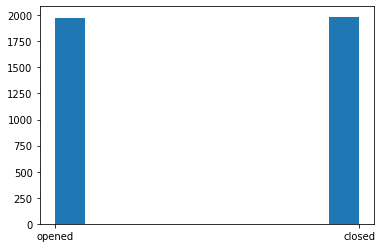

In [12]:
fig = plt.figure()
_ = plt.hist(labels)
fig.savefig('../plots/hist_annotations.png')

In [13]:
train_ann, test_ann = train_test_split(annotations, test_size=0.1, shuffle=True)

# Dataset class

In [14]:
from PIL import Image 

In [15]:
class EyesDataset(Dataset):
    def __init__(self, annotations, mode):
        super().__init__()
        self.annotations = annotations
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.annotations)
     
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
        augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(24, scale=(0.8, 1), ratio=(0.75, 1.3333333333333333), interpolation=2),
#             transforms.RandomPerspective(distortion_scale=0.3, p=0.9, interpolation=3, fill=0),
            transforms.RandomAffine(degrees=20, shear=20, resample=False),
            transforms.Resize((24, 24))
        ])
        
        x = self.load_sample(self.annotations[index][0])
        label = (lambda x : 0 if (x == 'closed') else 1)(self.annotations[index][1])
        label = np.array(label, dtype='float32')
                                                         
        if self.mode == 'train':
            x = augmentation(x)
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        return x, label
        
    def _prepare_sample(self, image):
        image = image.resize((24, 24))
        return np.array(image)

In [16]:
train_dataset = EyesDataset(train_ann, 'train')
test_dataset = EyesDataset(test_ann, 'test')

In [17]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)

# Train functions

In [18]:
def train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    for train_x, train_y in train_loader:
        train_x = train_x.to(DEVICE)
        train_y = train_y.to(DEVICE).view(-1, 1)
        # zero  gradients
        optimizer.zero_grad()

        # get the output from the model
        output = net(train_x)
        output = torch.sigmoid(output)
        # calculate loss
        loss = loss_fn(output, train_y)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1
    train_ep_loss /= counter
   
    return train_ep_loss

In [19]:
def test_epoch(net, test_loader, loss_fn):
    net.eval()
    test_ep_loss = 0.
    test_ep_acc = 0.
    test_ep_f1 = 0.
    test_ep_eer = 0.
    
    counter = 0.
    for test_x, test_y in test_loader:
        test_x = test_x.to(DEVICE)
        test_y = test_y.to(DEVICE).view(-1, 1)
        
        output = net(test_x)
        output = torch.sigmoid(output)
        
        # calculate loss and metrics
        loss = loss_fn(output, test_y)
        acc = accuracy_score(test_y.cpu().detach(), (output.cpu().detach() > 0.5))
        f1 = f1_score(test_y.cpu().detach(), (output.cpu().detach() > 0.5).type(torch.float32))
        eer = eer_score(test_y.cpu().detach(), (output.cpu().detach() > 0.5).type(torch.float32))
        
        test_ep_loss += loss.item() 
        test_ep_acc += acc
        test_ep_f1 += f1
        test_ep_eer += eer
        
        counter += 1

    test_ep_loss /= counter
    test_ep_acc /= counter
    test_ep_f1 /= counter
    test_ep_eer /= counter
    
    return test_ep_loss, test_ep_acc, test_ep_f1, test_ep_eer

In [20]:
def train(net, train_loader, test_loader, loss_fn, optimizer, epochs, scheduler=None):
    
    train_losses = []
    test_losses = []
    
    for e in tqdm(range(epochs)):

        train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
        if scheduler:
            scheduler.step()
        with torch.no_grad():
            test_loss, test_acc, test_f1, test_eer = test_epoch(net, test_loader, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        if e%5 == 0:
            print("Epoch: {}/{}...".format(e+1, epochs),
                          "Loss: {:.6f}...".format(train_loss),
                          "Test Loss: {:.6f}...".format(test_loss), 
                          "Test acc: {:.6f}".format(test_acc),
                          "Test f1: {:.6f}".format(test_f1), 
                          "Test eer: {:.6f}".format(test_eer))
    return train_losses, test_losses

# Model

In [37]:
mobilenet = models.mobilenet_v2()

In [38]:
mobilenet.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [39]:
mobilenet.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False), 
    nn.Linear(in_features=1280, out_features=100, bias=True), 
    nn.ReLU(), 
    nn.Linear(in_features=100, out_features=1, bias=True)
)

# Train

In [40]:
mobilenet = mobilenet.to(DEVICE)

optimizer = torch.optim.Adam(mobilenet.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
criterion = nn.BCELoss()

In [42]:
mn_train_losses, mn_test_losses = train(mobilenet, train_loader, test_loader, criterion, optimizer, 50)

  2%|▏         | 1/50 [00:07<06:00,  7.35s/it]

Epoch: 1/50... Loss: 0.628983... Test Loss: 0.519862... Test acc: 0.755609 Test f1: 0.774676 Test eer: 0.325634


 12%|█▏        | 6/50 [00:43<05:15,  7.18s/it]

Epoch: 6/50... Loss: 0.374071... Test Loss: 0.304638... Test acc: 0.893429 Test f1: 0.896408 Test eer: 0.117134


 22%|██▏       | 11/50 [01:21<04:52,  7.51s/it]

Epoch: 11/50... Loss: 0.293649... Test Loss: 0.250298... Test acc: 0.913462 Test f1: 0.914232 Test eer: 0.095537


 32%|███▏      | 16/50 [01:58<04:16,  7.56s/it]

Epoch: 16/50... Loss: 0.250412... Test Loss: 0.217398... Test acc: 0.920673 Test f1: 0.925225 Test eer: 0.105903


 42%|████▏     | 21/50 [02:36<03:37,  7.50s/it]

Epoch: 21/50... Loss: 0.237992... Test Loss: 0.229650... Test acc: 0.930288 Test f1: 0.928881 Test eer: 0.050800


 52%|█████▏    | 26/50 [03:14<03:00,  7.53s/it]

Epoch: 26/50... Loss: 0.231831... Test Loss: 0.227988... Test acc: 0.899038 Test f1: 0.907056 Test eer: 0.172308


 62%|██████▏   | 31/50 [03:52<02:22,  7.52s/it]

Epoch: 31/50... Loss: 0.191014... Test Loss: 0.216942... Test acc: 0.930288 Test f1: 0.934578 Test eer: 0.108724


 72%|███████▏  | 36/50 [04:30<01:46,  7.60s/it]

Epoch: 36/50... Loss: 0.186500... Test Loss: 0.194322... Test acc: 0.923077 Test f1: 0.928447 Test eer: 0.114172


 82%|████████▏ | 41/50 [05:08<01:08,  7.58s/it]

Epoch: 41/50... Loss: 0.198938... Test Loss: 0.173778... Test acc: 0.943910 Test f1: 0.945263 Test eer: 0.074556


 92%|█████████▏| 46/50 [05:46<00:30,  7.57s/it]

Epoch: 46/50... Loss: 0.174388... Test Loss: 0.168599... Test acc: 0.946314 Test f1: 0.946926 Test eer: 0.061845


100%|██████████| 50/50 [06:17<00:00,  7.55s/it]


In [43]:
torch.save(mobilenet.state_dict(), '../weights/weights_mn_50.pth')

In [44]:
mobilenet.load_state_dict(torch.load('../weights/weights_mn_50.pth'))

<All keys matched successfully>

In [45]:
_, acc, f1, eer = test_epoch(mobilenet, test_loader, criterion)
print('acc: {:.6f}\nf1 : {:.6f}\neer : {:.6f}'.format(acc, f1, eer))

acc: 0.930288
f1 : 0.931135
eer : 0.080473


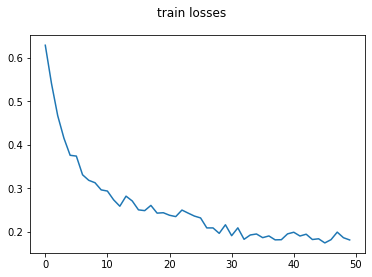

In [52]:
fig1 = plt.figure()
plt.plot(mn_train_losses)
fig1.suptitle('train losses')
fig1.savefig('../plots/train_losses.png')

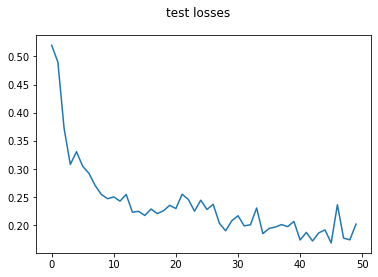

In [53]:
fig2 = plt.figure()
plt.plot(mn_test_losses)
fig2.suptitle('test losses')
fig1.savefig('../plots/test_losses.png')

In [133]:
def openEyeCheck(inpIm, model=None):
    def load_sample(file):
        image = Image.open(file)
        image.load()
        return image
    if model is None:
        model = models.mobilenet_v2()
        model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False), 
            nn.Linear(in_features=1280, out_features=100, bias=True), 
            nn.ReLU(), 
            nn.Linear(in_features=100, out_features=1, bias=True)
        )
        model = model.to(DEVICE)
        model.load_state_dict(torch.load('../weights/weights_mn_50.pth'))
        model.eval()
    
    image = torch.FloatTensor(np.array(load_sample(inpIm))).to(DEVICE).view(1,1,24,24) / 255
    out = torch.sigmoid(model(image)) > 0.5
    
    return int(out.item())

In [134]:
openEyeCheck('../input/EyesDataset/000000.jpg')

1